In [ ]:
from langchain_openai import ChatOpenAI

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


from pydantic import BaseModel, Field
from typing_extensions import Literal

from langchain_core.messages import HumanMessage, SystemMessage


# use to spawn workers dinamicaly
from langgraph.constants import Send


import os
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model=os.getenv("LLM_MODEL", "gpt-4o-mini"),
    api_key=os.getenv("OPENAI_API_KEY"),

)


In [3]:
from typing import Annotated, List
import operator

# This is dinamic workflow, we dont know how many sections we will have

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [6]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    # what every worker writes in overlaping fields will be reflected in the completed_sections in State class
    completed_sections: Annotated[list, operator.add]


In [ ]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


# !!! takes WorkerState as input and returns WorkerState
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API to spawn workers dinamicaly
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

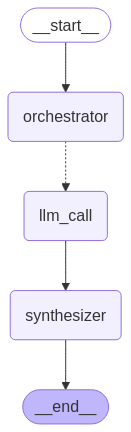

In [8]:
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
# start with orchestrator
orchestrator_worker_builder.add_edge(START, "orchestrator")
# decide how many llm call nodes we need and create
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [21]:
state = orchestrator_worker.invoke({"topic": "Create a short report on genai"})

state["sections"]

[Section(name='Introduction to Generative AI', description='An overview of generative AI, its significance, and applications in various industries, highlighting its transformative potential.'),
 Section(name='Types of Generative AI Models', description='Exploration of different generative AI models such as GANs (Generative Adversarial Networks), VAEs (Variational Autoencoders), and Transformers, explaining their functionalities.'),
 Section(name='Applications of Generative AI', description='Detailed discussion on how generative AI is being utilized in fields like art, music, gaming, and content creation, with examples of successful implementations.'),
 Section(name='Challenges and Ethical Considerations', description='Examination of the challenges faced by generative AI, including issues of bias, copyright, and the ethical implications of AI-generated content.'),
 Section(name='Future Trends in Generative AI', description='Insights into emerging trends and future advancements in genera

In [22]:
with open('reports/report3.md', 'w') as file:
    # Add some markdown content
    content = state["final_report"]
    file.write(content)

In [23]:
from IPython.display import Markdown

Markdown(state["final_report"])

### Introduction to Generative AI

Generative AI refers to a subset of artificial intelligence algorithms that can create new content, including text, images, audio, and video, typically based on patterns learned from existing data. Unlike traditional AI, which mainly focuses on recognizing and classifying existing information, generative AI is designed to generate original outputs that mimic human creativity. This technology has gained significant prominence in recent years due to advances in deep learning, notably through models such as generative adversarial networks (GANs) and transformer-based structures.

The significance of generative AI extends across multiple dimensions. First, it offers unparalleled opportunities for innovation, enabling businesses and individuals to create unique content with reduced time and effort. For instance, in the realm of digital art, graphic designers can harness generative AI tools to expedite the creative process and explore novel artistic styles that may not have been possible through manual methods alone. Furthermore, its application in content creation can streamline processes in journalism, marketing, and entertainment, enhancing productivity and lowering the barriers to entry in various creative fields.

Generative AI is making notable headway in several industries, transforming workflows and producing substantial efficiencies. In healthcare, for instance, it is used to generate synthetic medical data, which aids in training robust machine learning models while ensuring patient privacy. The finance sector benefits from generative AI through the creation of realistic financial scenarios for risk assessment and prediction modeling, allowing for better decision-making processes. Moreover, in the field of gaming, it allows for the automated generation of game levels and character designs, providing a more personalized and engaging experience for players.

As generative AI continues to evolve, its potential for transformation remains significant. It challenges traditional notions of authorship and creativity, fostering discussions around intellectual property rights and ethical considerations. Organizations must navigate these challenges while harnessing the power of generative AI to drive innovation and maintain competitive advantage in an increasingly digital landscape. As such, understanding the potentialities and implications of this technology is critical for stakeholders across all sectors, marking generative AI as a fundamental component of the future of various industries.

---

### Types of Generative AI Models

Generative AI models have transformed the landscape of artificial intelligence, enabling machines to create content that mimics human-like creativity and understanding. Among these models, Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), and Transformers stand out for their unique functionalities and applications.

#### Generative Adversarial Networks (GANs)

Introduced by Ian Goodfellow and his collaborators in 2014, GANs consist of two neural networks—the generator and the discriminator—that work in opposition. The generator creates synthetic data, while the discriminator evaluates the authenticity of this data against real-world data. Through iterative training, the generator enhances its ability to produce realistic data, while the discriminator becomes more adept at distinguishing between genuine and synthetic inputs.

**Functionality**: The training process is characterized by a zero-sum game where the generator aims to fool the discriminator, and the discriminator strives to become more accurate in its judgments. This adversarial relationship fosters a cycle of continuous improvement, enabling GANs to produce high-quality images, music, and even video clips. Variants of GANs, like StyleGAN and CycleGAN, have been developed to further enhance the generation process, allowing for style transfer and high-resolution outputs.

#### Variational Autoencoders (VAEs)

VAEs, developed in 2013, are another class of generative models designed primarily for generating complex data structures. Unlike GANs, VAEs do not rely on adversarial training. Instead, they consist of two main components: the encoder, which compresses input data into a latent space representation, and the decoder, which reconstructs the data from this representation.

**Functionality**: VAEs use probabilistic graphical models and introduce a regularization term that encourages the latent space to follow a specific distribution (commonly Gaussian). This characteristic enables VAEs not only to generate new examples similar to the training data but also to facilitate smooth interpolations in the latent space. VAEs are particularly effective in tasks such as image synthesis, anomaly detection, and data compression.

#### Transformers

Transformers have revolutionized the field of natural language processing (NLP) but have also become increasingly prevalent in generative tasks across various domains, including text and image generation. These models rely on a mechanism called self-attention, allowing them to weigh the significance of different words or elements in the input data dynamically.

**Functionality**: Transformers work by processing sequences of data in parallel, which enhances their efficiency and scalability compared to traditional sequence-based models like RNNs. They can generate coherent and contextually relevant sequences, making them particularly suitable for applications like text generation, translation, and summarization. Models such as GPT (Generative Pre-trained Transformer) illustrate the power of this architecture, demonstrating the capability to create human-like text based on prompts.

### Conclusion

In summary, GANs, VAEs, and Transformers are foundational generative AI models, each with distinct mechanisms and applications. GANs excel in generating high-quality realistic data through adversarial training, VAEs provide a probabilistic approach to data generation and latent space manipulation, while Transformers have set new benchmarks for sequential data generation. As research continues to evolve, these models are expected to integrate and innovate further, expanding the possibilities of generative AI.

---

### Applications of Generative AI

Generative AI has emerged as a groundbreaking technology with wide-ranging applications across various fields, including art, music, gaming, and content creation. Through the ability to analyze vast datasets and generate new content that simulates human creativity, generative AI is reshaping how we understand and interact with creative processes. Below is a detailed discussion on its applications, including notable examples of successful implementations.

#### 1. Art

In the realm of visual arts, generative AI tools have enabled artists to create unique pieces that blend human intuition and machine learning. Notably, the artwork "Edmond de Belamy," created by the Paris-based art collective Obvious, utilized a generative adversarial network (GAN) to produce a portrait that was auctioned for over $400,000 in 2018. The piece's success stirred conversations about authorship and creativity in the age of AI. Other platforms, such as DeepArt and Artbreeder, allow users to blend styles and create new artworks, democratizing the art creation process and providing artists with innovative tools for exploration.

#### 2. Music

In music, generative AI has been leveraged to compose original pieces or assist musicians in the creative process. The AI music composition tool AIVA (Artificial Intelligence Virtual Artist) has been utilized to create soundtracks for films and video games. It analyzes classical music to learn various styles and then produces new compositions that fit the desired criteria. Similarly, OpenAI's MuseNet employs deep learning to generate music across various genres and style combinations, allowing creators to explore uncharted musical territories. Music generators, such as Amper Music, enable individuals to create custom tracks for their projects without requiring a formal background in music production.

#### 3. Gaming

The gaming industry has also seen innovative applications of generative AI, particularly in procedural content generation. Games like "No Man's Sky" use algorithms to create vast, explorable galaxies, ensuring that players encounter unique worlds each time they play. Such technology allows developers to reduce the workload associated with content creation while enriching the player's experience with infinite possibilities. Additionally, AI Dungeon leverages machine learning to create interactive storytelling experiences, generating narratives based on user input and choices, exemplifying how generative AI can enhance narrative complexity in gaming.

#### 4. Content Creation

Content creation has been profoundly affected by generative AI, which can automate tasks, generate ideas, and produce written content. Tools like OpenAI's GPT-3 have set new standards for natural language processing, allowing for the generation of human-like text across various formats, including articles, blogs, and stories. Businesses and content marketers are utilizing AI-driven platforms to create engaging marketing copy, automate customer service responses, and even draft entire blog posts, saving time and resources while maintaining content quality. Noteworthy implementations include platforms like Jasper and Writesonic, which help professionals streamline the writing process.

### Conclusion

The applications of generative AI are expanding rapidly, bridging the gap between technology and creativity in ways that were previously unimaginable. As the technology continues to refine its capabilities, its integration into art, music, gaming, and content creation is likely to deepen, prompting new dialogues about the nature of creativity, authorship, and the role of technology in the creative process. Each successful implementation provides unique insights and raises questions that will shape the future of generative AI across disciplines.

---

### Challenges and Ethical Considerations

The rapid advancement of generative artificial intelligence (AI) technologies has ushered in significant opportunities across various sectors, from content creation to scientific research. However, these advances are accompanied by a host of challenges and ethical considerations that must be rigorously examined to ensure responsible and equitable use.

**1. Bias in AI-generated Content**

One of the foremost challenges facing generative AI systems is the persistence of bias within their algorithms. Generative AI models are often trained on vast datasets that may inadvertently contain societal biases reflected in the data. As a result, these AI systems can reproduce and amplify existing stereotypes or prejudices, leading to outputs that can misrepresent or marginalize certain groups. For instance, research has demonstrated that language models can generate biased or offensive content, thereby perpetuating harmful narratives. Addressing these biases requires a multifaceted approach including improved data curation, bias detection, and the development of more inclusive training methodologies.

**2. Copyright and Intellectual Property Issues**

The intersection of generative AI and copyright law presents a complex challenge. As these models create original content based on learned patterns, questions arise regarding ownership and intellectual property rights. Traditional copyright frameworks struggle to accommodate AI-generated works because they do not easily fit into the categories of human authorship established by current legal standards. This ambiguity raises legal and economic implications, particularly for creators whose original works form the basis of the training datasets. Ensuring fair attribution, compensation, and the protection of intellectual property rights is critical as generative AI becomes increasingly prevalent.

**3. Ethical Implications of AI-generated Content**

The ethical landscape surrounding generative AI is fraught with concerns about authenticity, accountability, and the potential for misuse. AI-generated content can be used to create deepfakes or misinformation, posing threats to privacy, security, and trust in media. Furthermore, the ability of generative AI to produce highly realistic outputs raises questions about the definition of authorship and the value of creativity itself. As generative technologies evolve, it becomes imperative to establish ethical guidelines and industry standards to navigate these complexities, ensuring that AI serves to augment human capabilities rather than undermine societal values.

**4. Social and Economic Disparities**

The deployment of generative AI technologies can exacerbate existing social and economic disparities. Access to cutting-edge AI tools is often limited to those with the requisite technical skills and resources. As a result, individuals and communities with fewer resources may be excluded from leveraging the transformative benefits of generative AI, widening the digital divide. Policymakers and industry leaders must work collaboratively to democratize access to these technologies and implement strategies that promote inclusive participation in the AI revolution.

In conclusion, while generative AI holds immense potential to revolutionize various facets of society, it also presents significant challenges and ethical dilemmas that necessitate careful consideration. Addressing these issues through proactive measures, such as bias mitigation, legal reform, ethical frameworks, and equitable access, is essential to harnessing the full benefits of generative AI while safeguarding against its risks.

---

## Future Trends in Generative AI

As generative AI continues to evolve at an unprecedented pace, several key trends are emerging that suggest substantial impacts on both society and various industries. These trends reflect advancements in technology, shifts in user expectations, and the growing integration of AI into everyday life.

### 1. Enhanced Personalization

One notable trend is the move towards hyper-personalization powered by generative AI. By leveraging vast datasets and deep learning algorithms, organizations are expected to create highly customized experiences for users across different platforms, from retail to entertainment. This level of personalization could reshape customer engagement strategies, allowing businesses to predict needs and preferences with unprecedented accuracy.

### 2. Democratization of Content Creation

Recent advancements in generative AI tools have significantly lowered the barriers to content creation. As tools become more user-friendly and accessible, individuals and small businesses will increasingly harness AI to generate high-quality content, graphics, and even music. This democratization will encourage a diverse range of voices and creativity, potentially disrupting traditional media and entertainment industries.

### 3. Integration with Augmented and Virtual Reality

The convergence of generative AI with augmented reality (AR) and virtual reality (VR) is set to create immersive experiences that redefine how we interact with digital content. Industries such as gaming, real estate, and education are poised to benefit, as AI-generated environments and interactive narratives enhance user engagement and realism.

### 4. Ethical and Regulatory Frameworks

As the capabilities of generative AI expand, so too does the necessity for ethical considerations and regulatory frameworks. Issues surrounding data privacy, misinformation, and the potential for AI-generated deepfakes will spur discussions and actions aimed at establishing guidelines that protect users and ensure responsible AI development. Stakeholders will seek to balance innovation with ethical standards, leading to more transparent practices in AI deployment.

### 5. Advancements in Multimodal AI

The future of generative AI also lies in the advancement of multimodal AI systems, which can process and generate content across different formats—text, images, audio, and video. This capability will allow for more cohesive interactions and applications in areas like automated news generation, virtual assistants, and creative collaboration tools, broadening the scope of what AI can accomplish.

### 6. Industry-Specific Applications

Generative AI is expected to make significant inroads in a variety of sectors, including healthcare, finance, and manufacturing. For instance, in healthcare, generative AI could streamline drug discovery and patient care through the analysis of complex datasets. In finance, it could enhance fraud detection and personalized financial planning. These applications indicate a shift toward greater efficiency and innovation across industries.

### Conclusion

The trajectory of generative AI technology is poised for remarkable growth, carrying profound implications for society and diverse sectors. As these trends unfold, organizations, policymakers, and individuals must remain vigilant in navigating the challenges and opportunities presented by this transformative technology. Future advancements in generative AI have the potential to enrich lives, drive economic growth, and reshape cultural narratives, continuing the dialogue around responsible innovation in the AI landscape.

---

**Conclusion and Description**

In this report, we have explored the multifaceted dimensions of generative AI, highlighting its rapid development, diverse applications, and the significant societal implications that accompany its integration into various sectors. The key points addressed throughout our analysis are summarized as follows:

1. **Technological Advancements**: Generative AI has evolved considerably, leveraging deep learning and neural networks to produce high-quality outputs, ranging from text and images to music and video. These advancements have made generative AI tools more accessible and user-friendly, amplifying their usage across industries.

2. **Applications Across Industries**: From content creation and marketing to healthcare and entertainment, generative AI is transforming how industries operate. Businesses increasingly utilize these technologies to enhance productivity, streamline workflows, and craft personalized customer experiences. 

3. **Ethical Considerations**: The rise of generative AI has raised significant ethical questions, particularly regarding data privacy, misinformation, and the potential for misuse. Concerns over bias in AI-generated content and the implications of deepfakes underline the importance of developing robust ethical frameworks and regulatory measures to govern the responsible use of these technologies.

4. **Collaborative Potential**: Generative AI can complement human creativity rather than replace it. Through collaborative efforts, professionals can harness AI tools to augment their capabilities, resulting in innovative outputs and a redefined creative process across various domains.

5. **Continued Research and Development**: The field of generative AI is still in its nascent stages, with ongoing research dedicated to improving model efficiency, sustainability, and transparency. Future advancements could lead to even more sophisticated applications and a deeper understanding of AI’s impact on human society.

Reflecting on the future of generative AI, it is clear that its trajectory will profoundly influence multiple facets of daily life and global economies. As we stand on the threshold of this technological revolution, the necessity for collaborative governance and ethical stewardship becomes paramount. Stakeholders—including researchers, policymakers, businesses, and community representatives—must engage in continuous dialogue to address emergent challenges and harness generative AI's potential for societal good.

Looking ahead, the implications of generative AI on employment, education, and social interaction are immense. It is essential to prepare workforces for the shifting landscape wrought by these technologies, ensuring that individuals possess the skills needed to collaborate effectively with AI systems. Education systems may need to adapt to emphasize digital literacy and critical thinking skills in an era increasingly influenced by AI.

In conclusion, while generative AI presents exciting opportunities for innovation and creativity, it also brings forth challenges that must be addressed thoughtfully and proactively. With strategic foresight, societal collaboration, and a commitment to responsibility, generative AI can contribute to a future that is not only technologically advanced but also equitable and beneficial for all.